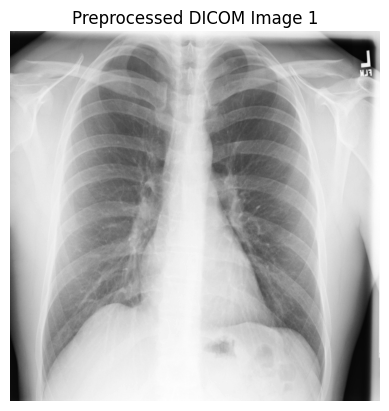

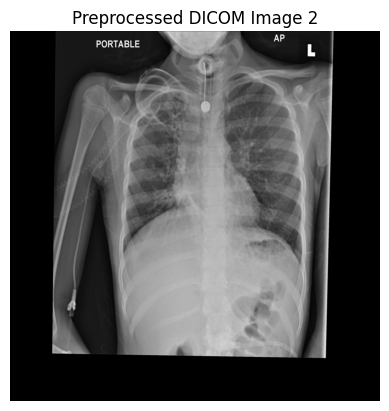

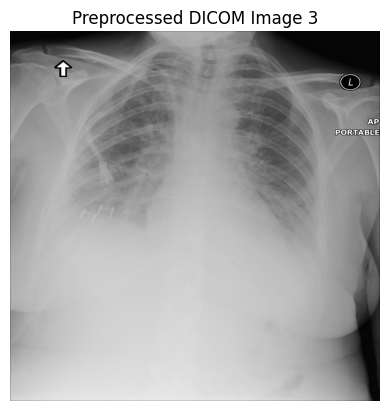

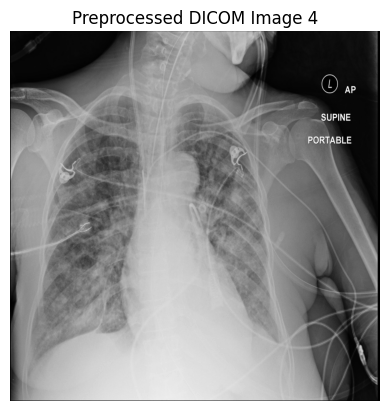

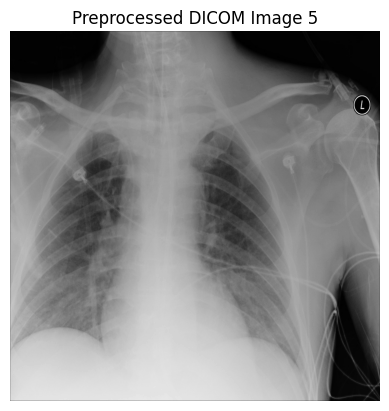

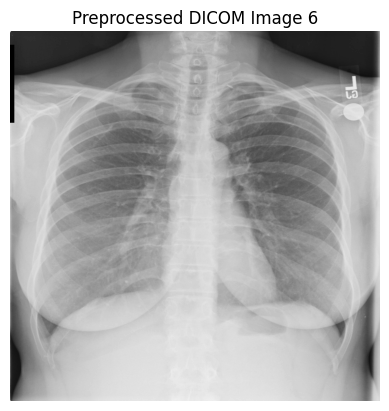

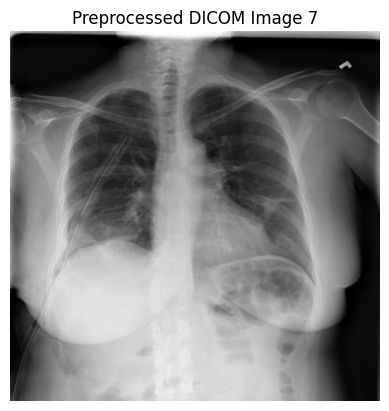

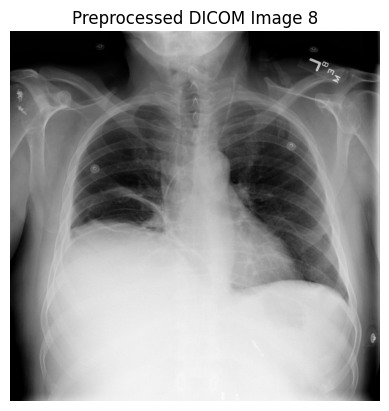

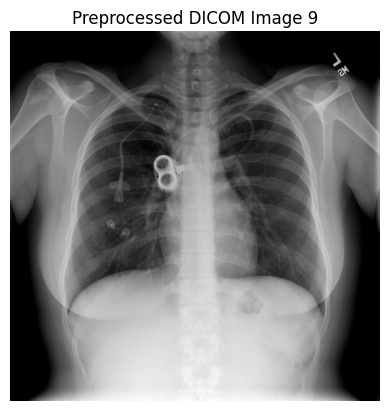

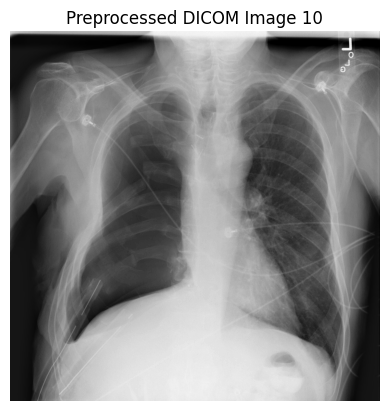

In [4]:
# Import necessary libraries
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import os

# Function to preprocess DICOM images
def preprocess_dicom_image(file_path):
    """
    This function reads a DICOM file, extracts the image data, and normalizes the pixel values.
    
    Parameters:
    file_path (str): Path to the DICOM file
    
    Returns:
    np.array: Preprocessed image data
    """
    # Load the DICOM file
    dicom_file = pydicom.dcmread(file_path)
    
    # Extract image data as a numpy array
    image_data = dicom_file.pixel_array
    
    # Normalize the pixel values to the range 0-1
    image_data = image_data / np.max(image_data)
    
    return image_data

# Directory containing DICOM files
dicom_dir = "dicom_files"

# List all DICOM files in the directory
dicom_files = [os.path.join(dicom_dir, f) for f in os.listdir(dicom_dir) if f.endswith('.dcm')]

# Preprocess and display the first 5 DICOM images
for i, dicom_file in enumerate(dicom_files[:10]):
    # Preprocess the DICOM image
    preprocessed_image = preprocess_dicom_image(dicom_file)
    
    # Display the preprocessed image
    plt.figure()
    plt.imshow(preprocessed_image, cmap='gray')
    plt.title(f'Preprocessed DICOM Image {i+1}')
    plt.axis('off')
    plt.show()